In [1]:
from tensorflow import keras

import tensorflow as tf
import random as python_random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from matplotlib.patches import Arrow

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

# Homework 3 - Neural Network for Classification
## Overview
* Binary Classification
* Hyperparameter tuning
* Multi-Class Classification

## Background:

In the hands-on session we already gained some experience with neural network for regression. In this homework we will focus on classification problem instead, and will practice with hyperparameter tuning. Specifically, the classification problem will be divided into two cases: `Binary Classification` and `Multi-Class Classification`. In Binary Classification the samples are only classified into two classes, while in Multi-Class Classification the samples are classified into more than two classes. In both cases the classes are mutually exclusive, which means one sample cannot belong to two or more classes at the same time. 

The dataset is the granta data we have used in week6 hands-on for KNN, SVM and decision tree. We will predict materials' tolerance to oxidation at 500C based on their Young's modulus and melting point.

* Compare classification neural network and regression neural network:

The hyperparameters of a neural network should be set according to the problem it is designed for. Table 1 and Table 2 below compare the hyperparameters for regression, binary classification and muilticlass classification neural network.

Typical Regression Neural Network architecture (Table 1):

| Hyperparameter | Typical Value |
|----------------|---------------|
| The number of input neurons | One per input feature |
| The number of hidden layers | Depends on the problem |
| The number of neurons per hidden layer | Depends on the problem |
| The number of output neurons | 1 per prediction dimension |
| Hidden activation | ReLU (or SELU) |
| Output activation | None or ReLU/Softplus (if positive outputs) or Sigmoid/Tanh (if bounded outputs) |
| Loss function | MSE or MAE/Huber (if outliers) |

Typical Classification Neural Network architecture (Table 2):

| Hyperparameter | Binary Classification | MuiltiClass Classification |
|--------------|-------------|--------------|
| Input and hidden layers | Same as regression | Same as regression |
| The number of output neurons | 1 | 1 per class |
| Output layer activation | Sigmoid | Softmax|
| Loss function | Binary Cross Entropy | Sparse Categorical Crossentropy or Categorical Crossentropy|

(References: Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow Concepts, Tools, and Techniques to Build Intelligent Systems by Aurélien Géron; Loss functions in Keras: https://keras.io/api/losses/ )

## Binary Classification

Same as what we did in the SVM part in week6, we combine the 'Acceptable', 'Limited use', 'Unacceptable' into one new class called 'Other', in order to convert this classification problem into a binary one.

In [2]:
# you should download the grantadata.p from canvas first
granta = pickle.load(open('grantadata.p','rb'))

In [3]:
x = granta[["Young's modulus (10^6 psi)",'Melting point (°F)']].values
y = granta['Oxidation at 500C'].copy()

for i in range(len(granta)):
    if granta['Oxidation at 500C'][i] in ['Acceptable', 'Limited use', 'Unacceptable']:
        y[i] = 'Other'

Labels should be converted to numerical values for the neural network to proceed. Here we convert the label 'Excellent' to 0 and 'Other' to 1.

In [4]:
labels_map = {'Excellent':0,'Other':1}
y_int = y.map(labels_map)

Train-test split, and normalize:

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y_int,
                                                    test_size=0.20,
                                                    random_state=111)

scaler = StandardScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

Construct the neural network:


In [6]:
#define a builder function
def binary_nn():
    model = Sequential()
    #here we make an explicit input layer, it simply passes the input data to the later layer
    model.add(Input(shape=x_train_norm.shape[1]))
    #hidden layers
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    #output layer
    #for binary classification,we use sigmoid and 1 neuron in the output layer
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

#create a model object
classifier = binary_nn()

2022-11-27 23:38:02.541166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Question 1: Note that here we set the parameter `metrics` in model.compile to be `accuracy`. What does it mean? (5 pts)
(you can refer to keras documentation about `metrics` here: https://keras.io/api/metrics/ )


It means that we use the metrics function to callout the Accuracy class.

Train the neural network:

In [7]:
history = classifier.fit(x_train_norm, y_train, validation_split=0.33, epochs=1000, batch_size=32,verbose=0)

2022-11-27 23:38:04.941660: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-27 23:38:04.943068: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Plot the 'history' of training:

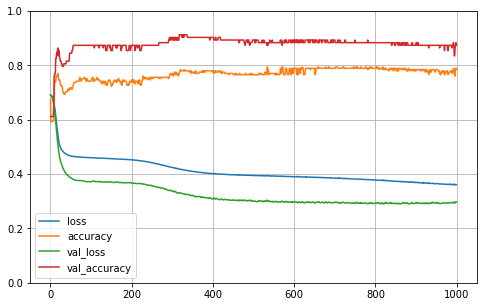

In [8]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Make prediction on test dataset:

In [9]:
y_test_predict = (classifier.predict(x_test_norm) > 0.5).astype('int32')

Note that the output of this classifier is one single value ranges from 0 to 1 (due to the nature of sigmoid function in the output layer). This value is actually inferrd as the probability that a sample belong to the class 1.
The samples with probability greater than 0.5 will be classified to class 1 ('Other'), and the samples with probablity equal or lower than 0.5 will be classified to class 0 ('Excellent').

Evaluate test accuracy:

In [10]:
test_loss = classifier.evaluate(x_test_norm, y_test)
print("test set accuracy is %.4f" % test_loss[1])

3/3 [==============================] - 0s 2ms/step - loss: 0.3688 - accuracy: 0.8077
test set accuracy is 0.8077


### To-do 1 (25 pts): 
A decision boundary can be visualized for this model(code provided below). Please make a scatterplot superposed on the given decision boundary plot. In the scatterplot show the training data points as circles with the color indicating its true category, show the testing data points as crosses with color indicating its predicted category.

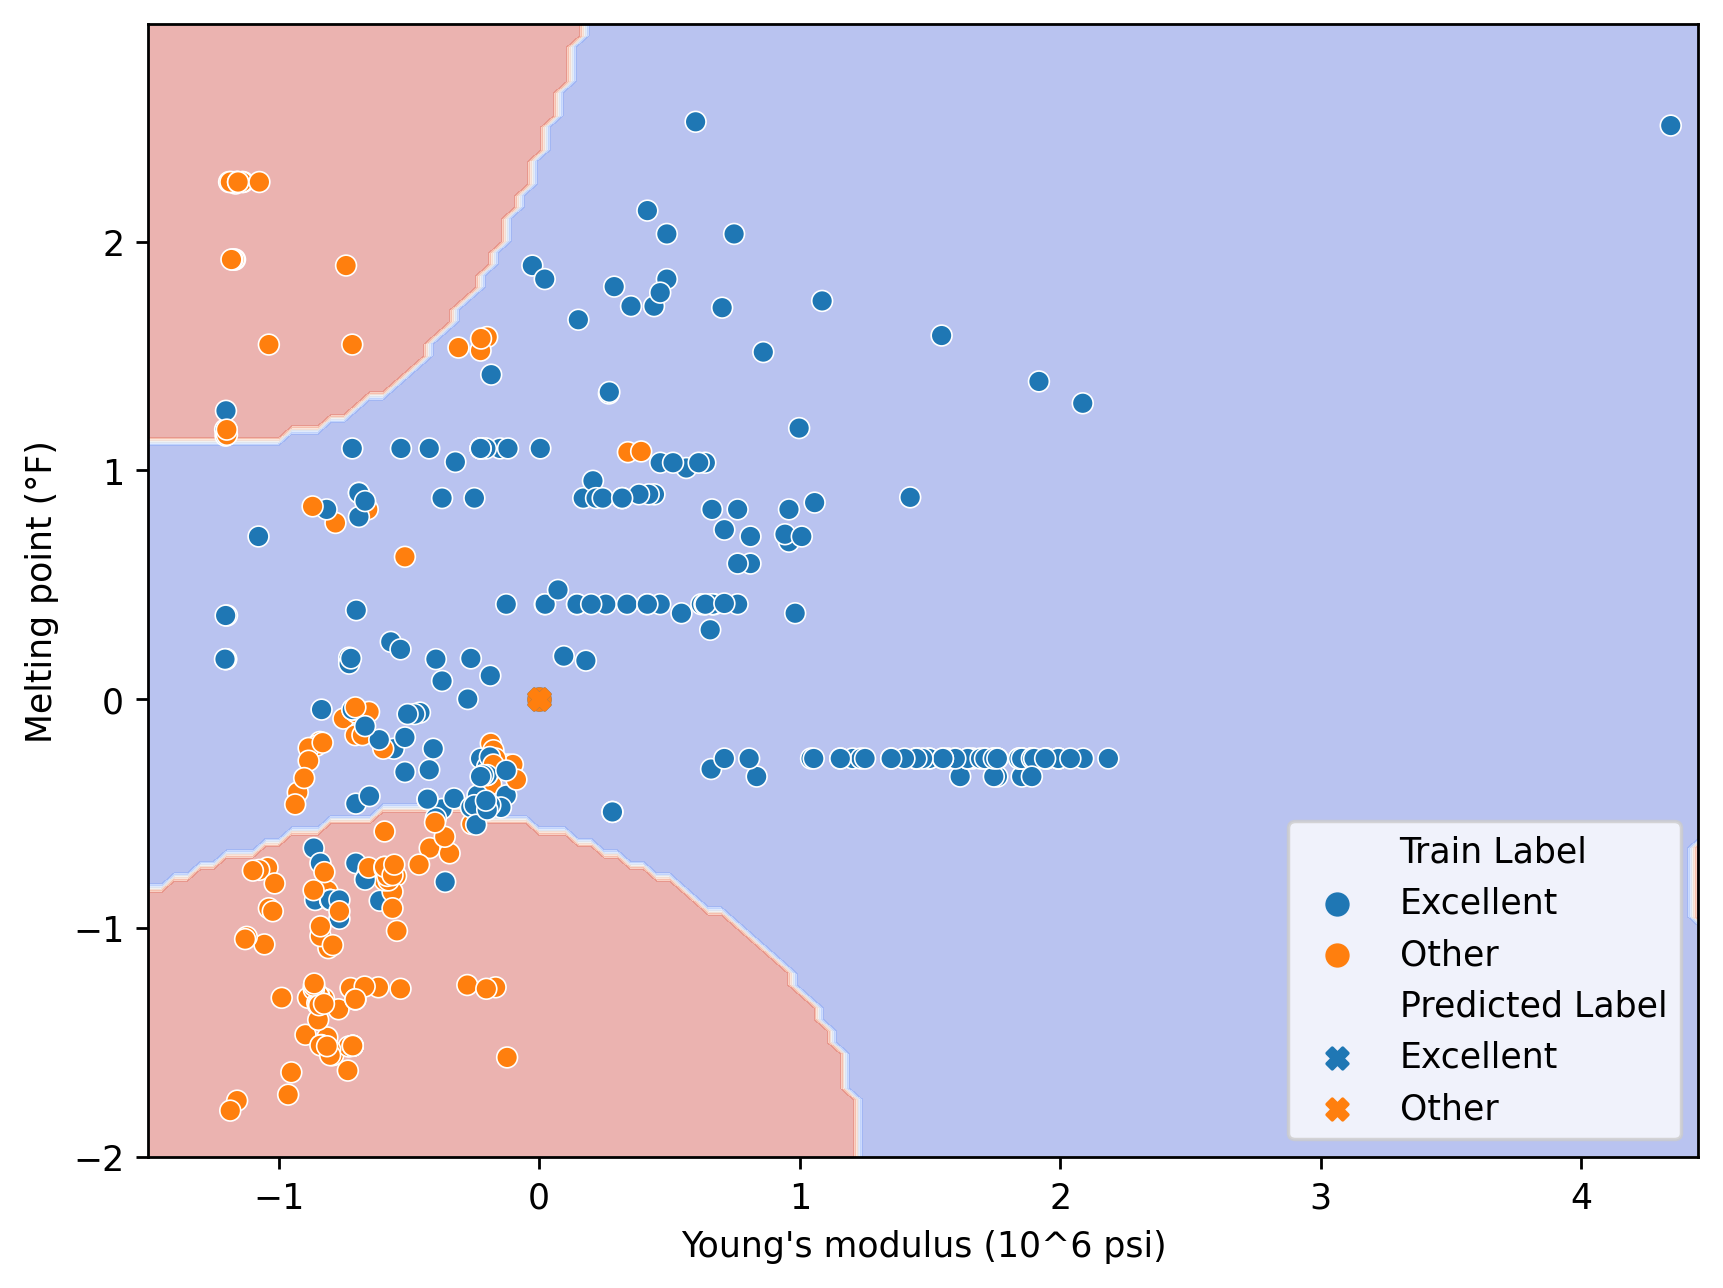

In [16]:
# create a meshgrid
xx, yy = np.meshgrid(np.arange(-1.5, 4.5, 0.05),
                     np.arange(-2, 3, 0.05))

# classify each points in the grid
z = (classifier.predict(np.c_[xx.ravel(), yy.ravel()])>0.5).astype("int32")
z = np.around(z)
z = z.reshape(xx.shape)

#plot the meshgrid
#The points classified to class 1 are shown in red
#the points classified to class 0 are shown in blue
fig,ax = plt.subplots(figsize=(8, 6),dpi=250)
plot1 = plt.contourf(xx, yy, z, cmap=plt.cm.coolwarm, alpha=0.4)

# please add your code here to create the scatter plot
# wrong: predict_results = x_test_norm.copy()
# wrong: predict_results['prediction'] = y_test
# wrong: train_results = x_train_norm.copy()
# wrong: train_results["training data"] = y_train.values

train_df = pd.DataFrame(x_train_norm, columns = ["Young's modulus (10^6 psi)", 'Melting point (°F)'])
train_df['Oxidation at 500C'] = y_train.tolist()
test_df = pd.DataFrame(x_test_norm, columns = ["Young's modulus (10^6 psi)", 'Melting point (°F)'])
test_df['Oxidation at 500C'] = y_test_predict


plot2 = sns.scatterplot(data=train_df, x="Young's modulus (10^6 psi)",y='Melting point (°F)',
                hue='Oxidation at 500C',legend=False)

plot3 = sns.scatterplot(data=test_df, x="Young's modulus (10^6 psi)",y='Melting point (°F)',
                hue='Oxidation at 500C',legend=False)


legend_elements = [Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0,label='Train Label'),
                   plt.scatter([0],[0],marker='o',color='tab:blue',label='Excellent'),
                  plt.scatter([0],[0],marker='o',color='tab:orange',label='Other'),
                  Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0,label='Predicted Label'),
                  plt.scatter([0],[0],marker='X',color='tab:blue',label='Excellent'),
                  plt.scatter([0],[0],marker='X',color='tab:orange',label='Other')]

ax.legend(handles=legend_elements, loc='lower right')


### Resource:

Feel free using the above code to explore how this decision boundary is affected by the number of layers and the activation functions of the hidden layer . For example, you could try using only one hidden layer, or try changing the activation function to be relu, and see how the boundary would change accordingly. 

* A neural network playground: https://playground.tensorflow.org/  . Have fun exploring various neural network constructions and parameters with nice visualization!

## Hyperparameter Tuning

Instead of trying different settings one by one like what we did in the hands-on session, we can use an algorithm to randomly search different combinations of hyperparameters, and find the one result the best performance. In this section, we will go over an example of searching the optimal combination of optimizer, learning rate and batch size for a neural network model. 

Firstly, we define a builder function named `binary_nn_builder`. We allow this function to have two parameters `optimizer` and `learning_rate`, which specify the type of optimizer and the value of learning rate to be used in this neural network model. It will be more obvious later why we need to set these two parameters.


In [17]:
def binary_nn_builder(optimizer,learning_rate):
    
    '''
    This is a builder function to define and compile a neural network
    
    Parameters:
        optimizer: a string specifies the optimizer to be used. It can be set to 'Adam' or 'SGD'.
        learning_rate: a float number specifies the learning rate.
    '''
    
    model = Sequential()
    model.add(Input(shape=x_train_norm.shape[1]))
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    if optimizer=='Adam':
        optimizer = keras.optimizers.Adam(lr=learning_rate)
    elif optimizer=='SGD':
        optimizer = keras.optimizers.SGD(lr=learning_rate)
        
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

Then we use a special wrapper class `KerasClassifier` to wrap this builder function. This KerasClassifier allows you to pass on all the parameters corresponding to the binary_nn_builder (i.e. optimizer,learning_rate), as well as some extra parameters related to the training process (such as `batch_size`, `epochs`). Again, it will be more clear later why we need this KerasClassifier wrapper.

In [18]:
# set the build function to be binary_nn_builder
# set the default value of batch_size to be 32

classifier_search = KerasClassifier(build_fn=binary_nn_builder,
                                    batch_size=32)

Next, we define a dictionary that gives the searching range for each hyperparameters we want to tune with. 

(<b>Important!</b>) To make sure those hyperparameter names can be recoginized by the hyperparameter searching algorithm, the keys of this dictionary should match with the name of the parameters that can be passed on to the KerasClassifier.

In [19]:
# a dictionary that gives the searching range for each parameters
parameters = {
    "optimizer": ['Adam','SGD'],
    "batch_size": np.arange(4,65).tolist(),
    "learning_rate":(0.1,0.03,0.01,0.003,0.001,0.0003,0.0001)
}

Here we define the searching range to be: optimizers in Adam or SGD, the batch size from 4 to 64, the learning rate from 0.0001 to 0.1.

Next, we call the `RandomizedSearchCV` to configure a hyperparameter searching. The parameter `estimator` should be the KerasClassifier object we created above, and the parameter `param_distributions` should be the dictionary where we defined the searching range. 

The RandomizedSearchCV will then randomly generate some combinations of hyperparameters within the given searching range, for example, a possible combination could be (optimizer='SGD', batch_size=6, learning_rate=0.0003). The parameter `n_iter` specifies the number of such random hyperparameter combinations to be generated.

In [20]:
# define the randomized search
rnd_search_cv = RandomizedSearchCV(estimator=classifier_search,param_distributions=parameters,n_iter=20,cv=3,verbose=0,n_jobs=-1)

Finally, we use the `fit` method to perform the hyperparameter searching. 

It will iterate over all the generated hyperparameter combinations. For each hyperparameter combination, it will pass the values of these hyperparameters to the estimator (the KerasClassifier), then evaluate its performance on training data. It is important that the estimator should be able to pass on the hyperparameter values fed from RandomizedSearchCV. This is exactly why we need to set optimizer and learning_rate as the parameters of the builder function. The batch size value will be passed on through the batch_size parameter of KerasClassifier.

The performance of each hyperparameter combination will be evaluted by the `metrics` of the model obtained from k-fold cross validation. Recall that we have set the metrics of the neural network model to be 'accuracy' inside the builder function. Thus the algorithm will evaluate the test accuracy when performing the cross validation. 

In [21]:
# perform the random search on our training data
rnd_search_cv.fit(x_train_norm, y_train,verbose=0,epochs=100)

2022-11-27 23:46:59.539016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 23:46:59.539016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 23:46:59.540684: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

8/8 [==============================] - 0s 786us/step - loss: 0.4546 - accuracy: 0.7404


8/8 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.6058


4/4 [==============================] - 0s 1ms/step - loss: 0.6908 - accuracy: 0.5865


8/8 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.7308


5/5 [==============================] - 0s 1ms/step - loss: 0.6776 - accuracy: 0.6058


5/5 [==============================] - 0s 1ms/step - loss: 0.6772 - accuracy: 0.6058


RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4de03e6670>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'batch_size': [4, 5, 6, 7, 8, 9, 10, 11,
                                                       12, 13, 14, 15, 16, 17,
                                                       18, 19, 20, 21, 22, 23,
                                                       24, 25, 26, 27, 28, 29,
                                                       30, 31, 32, 33, ...],
                                        'learning_rate': (0.1, 0.03, 0.01,
                                                          0.003, 0.001, 0.0003,
                                                          0.0001),
                                        'optimizer': ['Adam', 'SGD']})

We can see the hyperparameter combination that results the best test accuracy: 

In [22]:
rnd_search_cv.best_params_

{'optimizer': 'Adam', 'learning_rate': 0.1, 'batch_size': 47}

We can save the model that uses the best hyperparameter combination:

In [23]:
optimal_model = rnd_search_cv.best_estimator_.model

Evaluate the best model on test dataset:

In [24]:
test_loss_optimal = optimal_model.evaluate(x_test_norm, y_test)
print("test set accuracy is %.4f" % test_loss_optimal[1])

3/3 [==============================] - 0s 2ms/step - loss: 0.3639 - accuracy: 0.8077
test set accuracy is 0.8077


### To-do 2 (40 pts): 
In the above example, we defined a neural network model by wrapping a builder function in a KerasClassifier, and we used the RandomizedSearchCV to find the best values for the hyperparameters of the model(optimizer,batch size,learning rate).

Now, please set the optimizer,batch size,learning rate of the model to be the optimal one you found, then use RandomizedSearchCV to search the best values of the hyperparameters: the number of neurons and the activation functions of the two hidden layers in the model. The searching range of the number of neurons should be from 4 to 20. The activation functions should be searched within 'tahn' and 'relu'.

Feel free to use different values of `n_iter`,`cv`,`epochs` than the example.

Hint: start with define a new builder function.

In [25]:
def nn_binary_finder(neurons_num, acti_func):
    # creating the layers of the NN
    ann = Sequential()
    ann.add(Input(shape=x_train_norm.shape[1]))
    ann.add((Dense(units=neurons_num, kernel_initializer='normal', activation=acti_func)))
    ann.add((Dense(units=neurons_num, kernel_initializer='normal', activation=acti_func)))
    ann.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.1)
                ,metrics=['accuracy'])
    return ann

In [26]:
# set the build function to be binary_nn_builder
# set the optimal value of batch_size to be 39

classifier_search_1 = KerasClassifier(build_fn=nn_binary_finder,
                                    batch_size=39)

In [27]:
# a dictionary that gives the searching range for each parameters
parameters_1 = {
    "acti_func": ['tahn','relu'],
    "neurons_num": np.arange(4,20).tolist()}

In [28]:
# define the randomized search
rand_search = RandomizedSearchCV(estimator=classifier_search_1,param_distributions=parameters_1,n_iter=25,cv=3,verbose=0,n_jobs=-1)

In [29]:
# perform the random search on our training data
rand_search.fit(x_train_norm, y_train,verbose=0,epochs=90)

3/3 [==============================] - 0s 1ms/step - loss: 1.5359 - accuracy: 0.3942


3/3 [==============================] - 0s 1ms/step - loss: 3.8979 - accuracy: 0.5481


3/3 [==============================] - 0s 2ms/step - loss: 2.0550 - accuracy: 0.2500


3/3 [==============================] - 0s 1ms/step - loss: 1.0422 - accuracy: 0.3750


3/3 [==============================] - 0s 1ms/step - loss: 1.2425 - accuracy: 0.5962


3/3 [==============================] - 0s 1ms/step - loss: 1.3374 - accuracy: 0.3654


3/3 [==============================] - 0s 1ms/step - loss: 2.5177 - accuracy: 0.3558


3/3 [==============================] - 0s 1ms/step - loss: 0.5252 - accuracy: 0.1250


3/3 [==============================] - 0s 1ms/step - loss: 1.8839 - accuracy: 0.4327


3/3 [==============================] - 0s 1ms/step - loss: 1.6663 - accuracy: 0.6731


3/3 [==============================] - 0s 4ms/step - loss: 1.8230 - accuracy: 0.6250


3/3 [==============================] - 0s 1ms/step - loss: 1.8668 - accuracy: 0.6058


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
39 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 157, in fit
    self.model = self.build_

3/3 [==============================] - 0s 1ms/step - loss: 2.1756 - accuracy: 0.4327


RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4de037d220>,
                   n_iter=25, n_jobs=-1,
                   param_distributions={'acti_func': ['tahn', 'relu'],
                                        'neurons_num': [4, 5, 6, 7, 8, 9, 10,
                                                        11, 12, 13, 14, 15, 16,
                                                        17, 18, 19]})

In [30]:
rand_search.best_params_

{'neurons_num': 4, 'acti_func': 'relu'}

## Multiclass classification

In the previous two sections, we used a binary classification neural network model to predict materials' tolerance to oxidation at 500C. It is a binary classification problem since the classes of 'oxidation at 500C' can only be either 'excellent', or 'Other'. In this section, we will move on to the multiclass classification case, that the 'oxidation at 500C' now can take 4 different classes: 'Excellent','Acceptable', 'Limited use', 'Unacceptable'. 

Recall that in the binary clasification problem, we converted the label  'excellent' and 'Other' to 0 and 1. For the multiclass classification case, there are two ways to convert the labels. You can convert the labels to integers by the `LabelEncoder`, or convert to the one-hot numeric array by the `LabelBinarizer`. The code for both methods is provided for you below. 

* Use the Label Encoder to convert the label:

In [31]:
# Label Encoder as example
le = LabelEncoder()
le.fit(granta['Oxidation at 500C'].values)
list(le.classes_)

['Acceptable', 'Excellent', 'Limited use', 'Unacceptable']

In [32]:
y_encode = le.transform(granta['Oxidation at 500C'].values)

In [33]:
y_encode

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 3, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 1, 1,
       1, 1, 1, 0, 0, 2, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 1, 1, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3,

The four labels are converted to 0,1,2,3.

* Use the LabelBinarizer to convert the label:

In [34]:
# One-hot encode as example
lb = LabelBinarizer()
lb.fit(granta['Oxidation at 500C'].values)
list(lb.classes_)

['Acceptable', 'Excellent', 'Limited use', 'Unacceptable']

In [35]:
y_onehot = lb.transform(granta['Oxidation at 500C'].values)

In [36]:
y_onehot

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])

The four labels are converted to [1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1].

3 hyperparameters of the neural network model should be modified from the binary classification case to the multiclass classification case (see Table 2 in the Background section): 

* The number of output neurons: For multiclass classification problem, the number of output neurons should equal to the number of classes. The output value for each neurons in the output layer will be a number between 0 and 1, which can be interpreted as a probability corresponding to each class. 
* The activation function in the output layer: You should use `Softmax` activation function in the output layer to ensure all the probabilities add up to one.
* Loss function: the way you converted the label will decide which loss function you should use for the model. `Sparse Categorical Crossentropy` should be used for label encoded case and `Categorical Crossentropy` should be used for one-hot encoded case.

### To-do 3 (30 pts): 

Please modify the previous model to fit this multiclass classification (all the hyperparameters are up to your choice). Use the 'Young's modulus', 'Melting point' data along with the converted labels for 'Oxidation at 500C' (choose either y_encode or y_onehot) to train this neural network and evaluate test accuracy. Plot the 'history' of training. hyperparameter tuning is not required.

Note: Please make sure you correctly set up the number of neurons and activation funciton in the output layer. Make sure you use appropriate loss function.  

In [40]:
x = granta[["Young's modulus (10^6 psi)", 'Melting point (°F)']].values
lb = LabelBinarizer()
lb.fit(granta['Oxidation at 500C'].values)
y_onehot = lb.transform(granta['Oxidation at 500C'].values)
y_int = y_onehot
x_train, x_test, y_train, y_test = train_test_split(x, y_int, 
                                                    test_size=0.20, shuffle=True)
scaler = StandardScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

def nn_multi():
    model = Sequential()
    model.add(Input(shape=x_train_norm.shape[1]))
    model.add(Dense(16, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(16, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='tanh'))
    # output layer
    # for binary classification, we use sigmoid and 4 neurons in the output layer
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

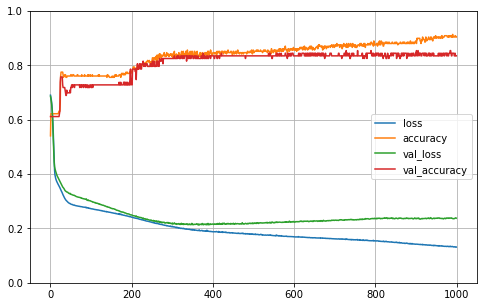

In [46]:
#create a model object
classifier = nn_multi()
history = classifier.fit(x_train_norm, y_train, validation_split=0.33, epochs=1000, batch_size=32, verbose=0)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [47]:
test_loss = classifier.evaluate(x_test_norm, y_test)
y_test_predict = classifier.predict(x_test_norm)
print("test set accuracy is %.4f" % test_loss[1])

3/3 [==============================] - 0s 2ms/step - loss: 0.2868 - accuracy: 0.7949
test set accuracy is 0.7949


In [48]:
def four_to_one(arr):
    lst = []
    for row in arr:
        lst.append(np.argmax(row))
    return np.array(lst)
four_to_one(y_test_predict)

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 2, 3, 1, 1, 3, 3, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 1, 2, 1, 1, 3, 1, 2, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

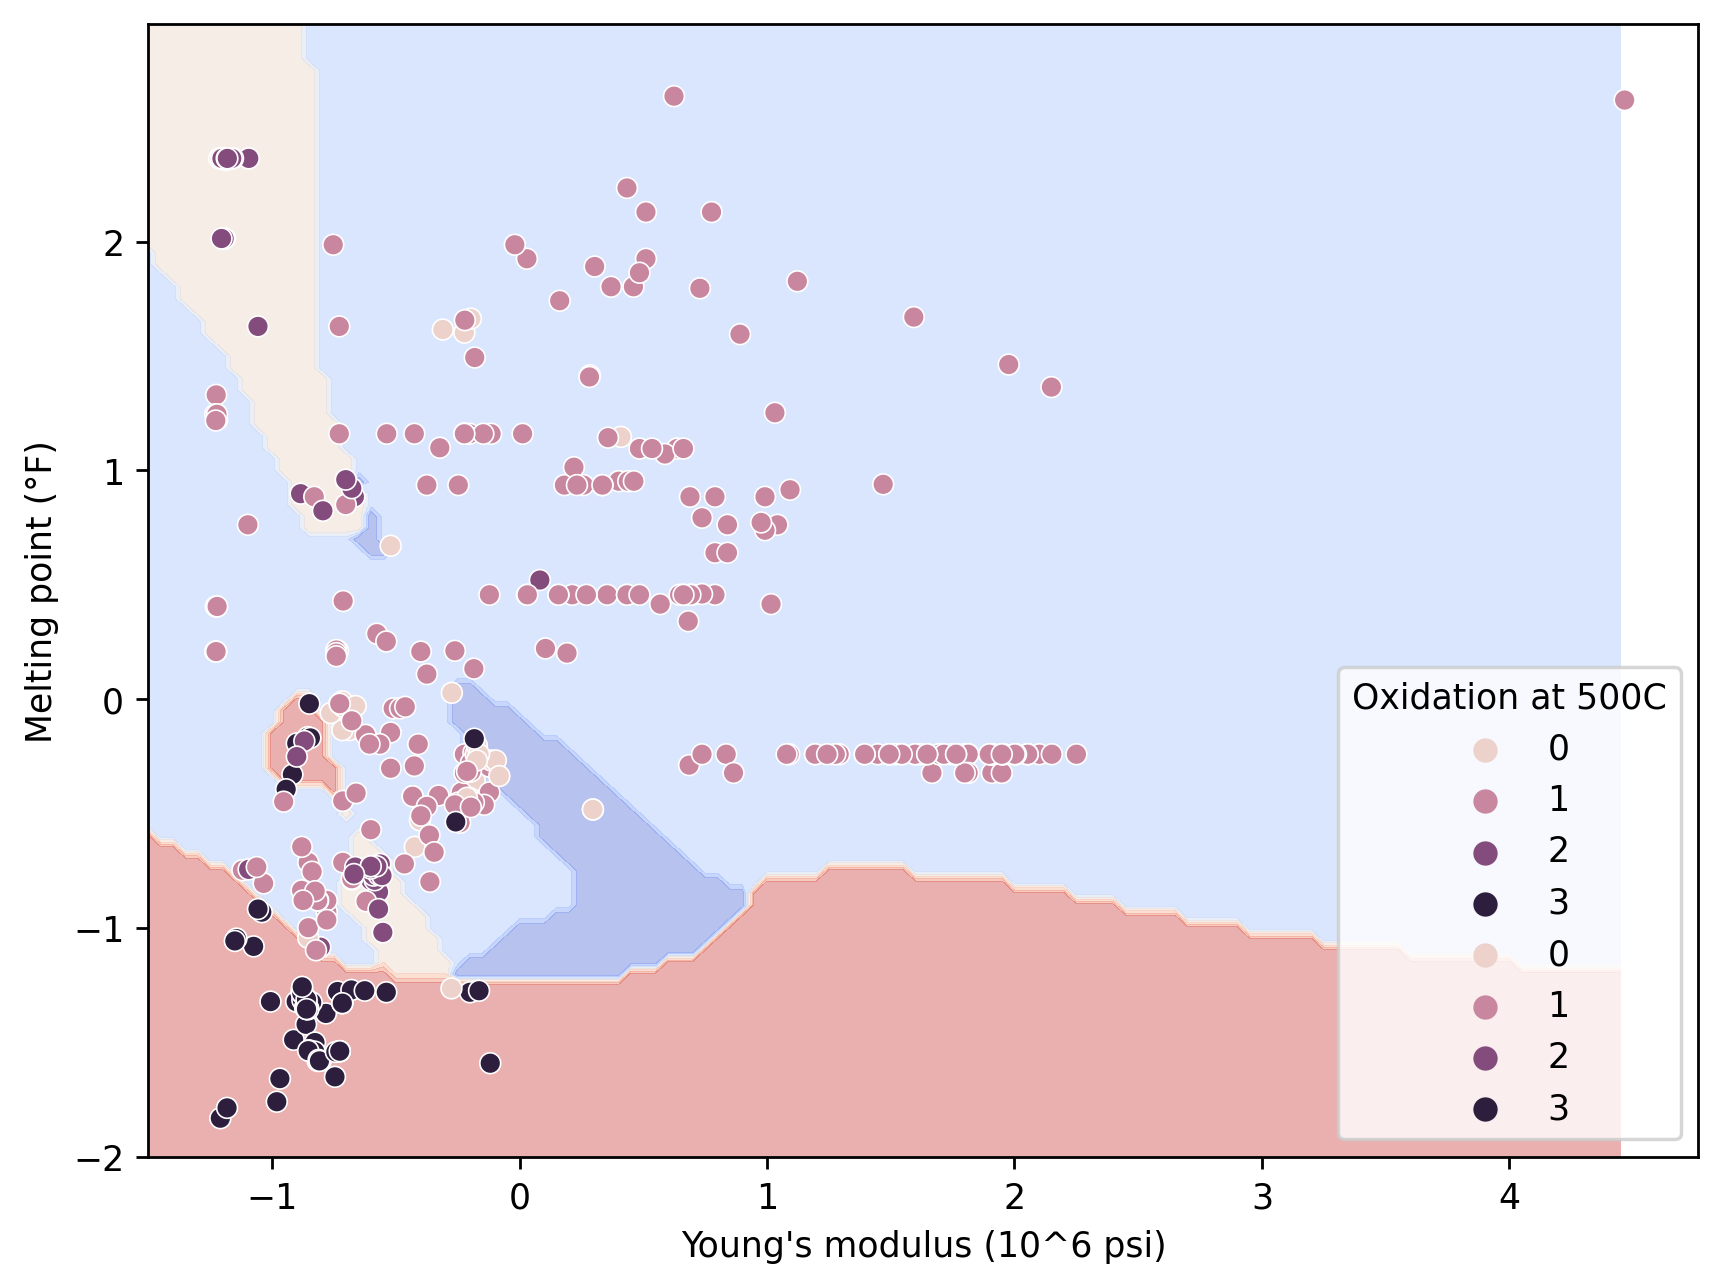

In [51]:
# create a meshgrid
xx, yy = np.meshgrid(np.arange(-1.5, 4.5, 0.05),
                     np.arange(-2, 3, 0.05))

# classify each points in the grid
z = four_to_one(classifier.predict(np.c_[xx.ravel(), yy.ravel()]))
z = np.around(z)
z = z.reshape(xx.shape)

#plot the meshgrid
fig,ax = plt.subplots(figsize=(8,6),dpi=250)
plot1 = plt.contourf(xx, yy, z, cmap=plt.cm.coolwarm, alpha=0.4)

train_df = pd.DataFrame(x_train_norm, columns = ["Young's modulus (10^6 psi)", 'Melting point (°F)'])
train_df['Oxidation at 500C'] = four_to_one(y_train)
test_df = pd.DataFrame(x_test_norm, columns = ["Young's modulus (10^6 psi)", 'Melting point (°F)'])
test_df['Oxidation at 500C'] = four_to_one(y_test_predict)

sns.scatterplot(x="Young's modulus (10^6 psi)",y='Melting point (°F)',data=train_df,
                hue='Oxidation at 500C')

sns.scatterplot(x="Young's modulus (10^6 psi)",y='Melting point (°F)',data=test_df,
                hue='Oxidation at 500C')

plt.show